In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup

from cryoS2Sdrop.dataloader import singleCET_dataset
from cryoS2Sdrop.model import Denoising_UNet
from cryoS2Sdrop.losses import self2self_L2Loss
from cryoS2Sdrop.trainer import denoisingTrainer
from cryoS2Sdrop.predict import load_model, predict_full_tomogram

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob

from torchsummary import summary
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
# logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/model_logs/version_3/')
logdir = os.path.join(PARENT_PATH, 'data/S2SDenoising/model_logs/version_4/')

with open(glob(logdir+'hparams.yaml')[0]) as f:
    hparams = yaml.load(f, Loader=yaml.BaseLoader)

ckpt_file = glob(logdir+'checkpoints/*.ckpt')[0]
model = load_model(ckpt_file, DataParallel=True)

cet_path = hparams['cet_path']
p = float(hparams['p']) # dropout (zeroing) probability
subtomo_length = int(hparams['subtomo_length'])
n_samples = int(hparams['n_samples'])
n_features = int(hparams['n_features'])

In [3]:
my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, n_samples=n_samples)
len(my_dataset)

75

# Single subtomo prediction

In [4]:
subtomo, target, mask = my_dataset[0]
subtomo, target, mask = subtomo.unsqueeze(0), target.unsqueeze(0), mask.unsqueeze(0) 
subtomo.shape

torch.Size([1, 50, 96, 96, 96])

In [21]:
denoised_subtomo = model(subtomo).squeeze().mean(axis=0).cpu().detach().numpy()
denoised_subtomo.shape

(96, 96, 96)

In [22]:
original_subtomo = (target + subtomo).squeeze().mean(axis=0).detach().numpy()
original_subtomo.shape

(96, 96, 96)

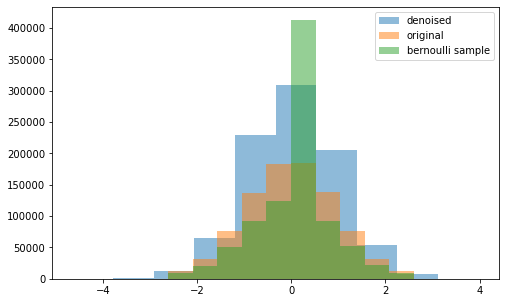

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(denoised_subtomo.flatten(), alpha=0.5, label='denoised')
plt.hist(original_subtomo.flatten(), alpha=0.5, label='original')
plt.hist(subtomo.squeeze()[0].flatten().numpy(), alpha=0.5, label='bernoulli sample')
plt.legend()

Text(0.5, 1.0, 'Input')

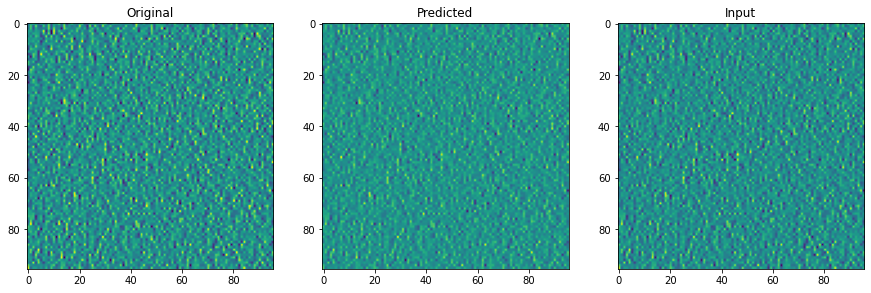

In [29]:
zidx = subtomo_length//2

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 10))
ax0.imshow(original_subtomo[zidx])
ax0.set_title('Original')
ax1.imshow(denoised_subtomo[zidx])
ax1.set_title('Predicted')
ax2.imshow(subtomo.mean(1).squeeze()[zidx])
ax2.set_title('Input')

(array([  2447.,   7338.,  27010.,  91102., 184811., 444613.,  90390.,
         27055.,   7533.,   2437.]),
 array([-4.7683716e-07, -3.8146973e-07, -2.8610231e-07, -1.9073487e-07,
        -9.5367433e-08,  0.0000000e+00,  9.5367433e-08,  1.9073487e-07,
         2.8610231e-07,  3.8146973e-07,  4.7683716e-07], dtype=float32),
 <BarContainer object of 10 artists>)

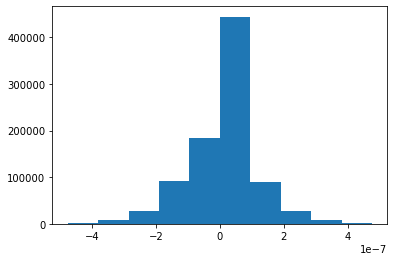

In [10]:
tomo_data = my_dataset.data

z0, y0, x0 = my_dataset.grid[0]
zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

original_subtomo0 = tomo_data[zmin:zmax, ymin:ymax, xmin:xmax]

zidx = subtomo_length//2

plt.hist((original_subtomo0-original_subtomo).numpy().flatten())

# Full tomogram prediction

In [11]:
torch.cuda.empty_cache()

In [16]:
batch_size= 10
denoised_tomo = []

for i in range(2):
    _denoised_tomo = predict_full_tomogram(my_dataset, model, batch_size)
    denoised_tomo.append(_denoised_tomo)
    
# take mean over all bernoulli batches
denoised_tomo = torch.stack(denoised_tomo).mean(0)
denoised_tomo.shape

100%|█████████████████████████████████████████| 8/8 [00:23<00:00,  2.99s/it]


torch.Size([232, 464, 464])

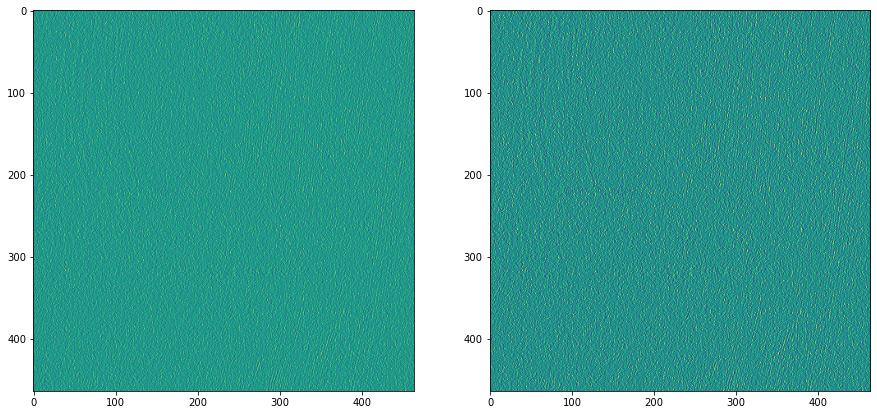

In [17]:
zidx = 200
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 10))
ax0.imshow(denoised_tomo[zidx])
ax1.imshow(tomo_data[zidx])

In [102]:
filename = cet_path.split('/')[-1].replace('.mrc', '_s2sDenoised.mrc')
filename = os.path.join(PARENT_PATH, 'data/S2SDenoising/denoised/%s' %filename)

write_array(denoised_tomo.numpy(), filename)